In [1]:
import pandas as pd
import mplfinance
from matplotlib.dates import date2num
from datetime import datetime
import numpy as np

from scipy import stats
import scipy.optimize
from scipy.optimize import OptimizeWarning
import warnings
import math


import os
import time
import nbimporter
from feature_functions import *
from tensorflow.keras.utils import plot_model

import sklearn
from collections import deque


Importing Jupyter notebook from feature_functions.ipynb


In [2]:
# import os
# os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

In [3]:
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
from numpy import sqrt

In [4]:
df=pd.read_csv('EURUSD.csv')
df.columns=['date','open','high','low','close','volume']
df.date = pd.to_datetime(df.date,format='%d.%m.%Y %H:%M:%S.%f')
df=df.set_index(df.date)
df=df[['open','high','low','close','volume']]

In [5]:
df = heikenashi(df,[1])
df.columns=['open','high','low','close']

In [6]:
res = momentum(df,[10]).close[10]
df=df.loc[df.index[10]:]
df['momentum'] = res

In [7]:
df['return'] = df['close'] - df['close'].shift(1)

df['label'] = df['return'].shift(-1)
df['label'] = df['label'].apply(lambda x: 1 if x>0.0 else 0)
df.dropna(inplace=True)



In [8]:
data = df.loc[:,['momentum','return','label']]

In [9]:
from sklearn import preprocessing

In [10]:
data_norm = data.copy()

In [11]:
momentum_ecartype = data['momentum'].std()
momentum_mean = data['momentum'].mean()
return_ecartype = data['return'].std()
return_mean = np.array(data['return']).mean()

In [12]:
data_norm.loc[:,'momentum'] = data_norm['momentum'] - momentum_mean
data_norm.loc[:,'momentum'] = data_norm['momentum']/momentum_ecartype
data_norm.loc[:,'return'] = data_norm['return'] - return_mean
data_norm.loc[:,'return'] = data_norm['return']/return_ecartype

In [13]:
n_features =60

In [14]:
start = time.time()
sequences = []
prev_hours = deque(maxlen=n_features)

for observation in data_norm.values:
    prev_hours.append([x for x in observation[:-1]])  
    if len(prev_hours) == n_features: 
        sequences.append([np.array(prev_hours), observation[-1]])
        
end = time.time()

print(end - start)


0.21198058128356934


In [15]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

In [16]:
X = np.array([exemple[0] for exemple in sequences])
Y = np.array([int(exemple[1]) for exemple in sequences])

train_len = int(len(sequences)*0.90)
valid_len = int(len(sequences)*0.95)

Y.shape = (Y.shape[0],1)
x_train=X[0:train_len]
y_train=Y[0:train_len]
x_valid = X[train_len:valid_len]
y_valid = Y[train_len:valid_len]
x_test = X[valid_len:]
y_test= Y[valid_len:]
y_train =np.array([int(x) for x in y_train ])
y_valid = np.array([int(x) for x in y_valid ])
y_test = [int(x) for x in y_test ]

In [17]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense,Dropout,BatchNormalization
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.callbacks import ModelCheckpoint

In [18]:
model = Sequential()
model.add(LSTM(128, input_shape=(x_train.shape[1:]),kernel_regularizer=tf.keras.regularizers.l2(0.01), return_sequences=True))
model.add(BatchNormalization())


model.add(LSTM(64,input_shape=(x_train.shape[1:]), return_sequences=True))
model.add(BatchNormalization())


model.add(LSTM(64,input_shape=(x_train.shape[1:])))
model.add(BatchNormalization())



model.add(Dense(32, activation='relu'))
model.add(Dense(16, activation='relu'))
model.add(Dense(8, activation='relu'))

model.add(Dense(2, activation='softmax'))

In [19]:
opt = tf.keras.optimizers.Adam(lr=0.001, decay=1e-6)

# Compile model
model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=opt,
    metrics=['accuracy']
)

In [20]:
BATCH_SIZE = 64
EPOCHS= 15

In [21]:
history = model.fit(
    x_train, y_train,
    validation_data=(x_valid,y_valid),
    batch_size=BATCH_SIZE,
    epochs = EPOCHS)

Train on 5574 samples, validate on 310 samples
Epoch 1/15
5574/5574 [==============================] - 24s 4ms/sample - loss: 0.7271 - accuracy: 0.5212 - val_loss: 0.7142 - val_accuracy: 0.4774
Epoch 2/15
5574/5574 [==============================] - 9s 2ms/sample - loss: 0.7035 - accuracy: 0.5292 - val_loss: 0.7089 - val_accuracy: 0.4581
Epoch 3/15
5574/5574 [==============================] - 9s 2ms/sample - loss: 0.6968 - accuracy: 0.5420 - val_loss: 0.7004 - val_accuracy: 0.4710
Epoch 4/15
5574/5574 [==============================] - 9s 2ms/sample - loss: 0.6941 - accuracy: 0.5420 - val_loss: 0.7048 - val_accuracy: 0.4613
Epoch 5/15
5574/5574 [==============================] - 9s 2ms/sample - loss: 0.6916 - accuracy: 0.5501 - val_loss: 0.7098 - val_accuracy: 0.4677
Epoch 6/15
5574/5574 [==============================] - 12s 2ms/sample - loss: 0.6810 - accuracy: 0.5797 - val_loss: 0.7040 - val_accuracy: 0.4935
Epoch 7/15
5574/5574 [==============================] - 4s 673us/sample - l

In [22]:
score = model.evaluate(x_test, np.array(y_test), verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.6786843257565652
Test accuracy: 0.62580645


In [23]:
# from numba import cuda 
# device = cuda.get_current_device()
# device.reset()

In [24]:
pred = [x[1] for x in np.round(model.predict(x_test))]
contracts  = 2000.0
commission = 0.0

In [25]:
def calc_profit(row):
    if row['won']:
        return abs(row['return'])*contracts - commission
    else:
        return -abs(row['return'])*contracts - commission


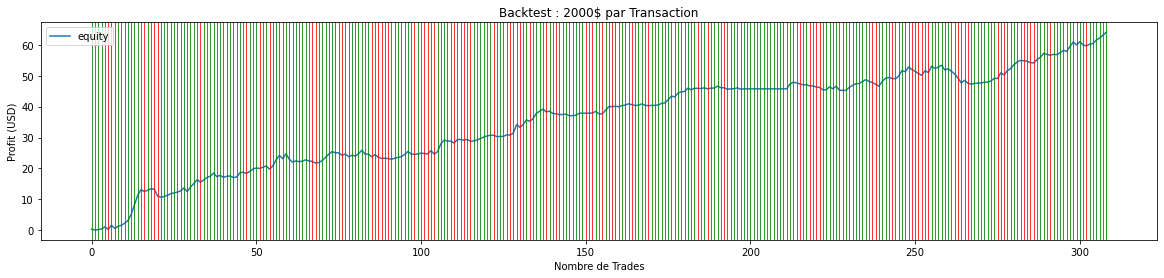

In [26]:
df_trade = pd.DataFrame(np.array(data['return'][valid_len+n_features-1:]), columns=['return'])
df_trade['label']  = y_test
df_trade['pred']   = pred
df_trade['won']    = df_trade['label'] == df_trade['pred']
df_trade.drop(df_trade.index[len(df_trade)-1], inplace=True)

df_trade['pnl'] = df_trade.apply(lambda row: calc_profit(row), axis=1)
df_trade['equity'] = df_trade['pnl'].cumsum()
df_trade.plot(y='equity', figsize=(20,4), title=f'Backtest : {int(contracts)}$ par Transaction')
plt.xlabel('Nombre de Trades')
plt.ylabel('Profit (USD)')
for r in df_trade.iterrows():
    if r[1]['won']:
        plt.axvline(x=r[0], linewidth=1, alpha=0.8, color='g')
    else:
        plt.axvline(x=r[0], linewidth=1, alpha=0.8, color='r')

Profit Net         : $64.04
Nombre de prédictions justes : 180
Number de prédictions fausses  : 114
Précision    : 61.22%
Moyenne par Transaction Gagnée       : $0.685
Moyenne par Transaction Perdue        : $-0.519
Gain le plus important    : $3.115
Perte la plus importante  : $-2.225


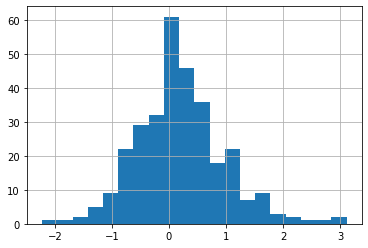

In [27]:
n_win_trades = float(df_trade[df_trade['pnl']>0.0]['pnl'].count())
n_los_trades = float(df_trade[df_trade['pnl']<0.0]['pnl'].count())
print("Profit Net         : $%.2f" % df_trade.tail(1)['equity'])
print("Nombre de prédictions justes : %d" % n_win_trades)
print("Number de prédictions fausses  : %d" % n_los_trades)
print("Précision    : %.2f%%" % (100*n_win_trades/(n_win_trades + n_los_trades)))
print("Moyenne par Transaction Gagnée       : $%.3f" % df_trade[df_trade['pnl']>0.0]['pnl'].mean())
print("Moyenne par Transaction Perdue        : $%.3f" % df_trade[df_trade['pnl']<0.0]['pnl'].mean())
print("Gain le plus important    : $%.3f" % df_trade[df_trade['pnl']>0.0]['pnl'].max())
print("Perte la plus importante  : $%.3f" % df_trade[df_trade['pnl']<0.0]['pnl'].min())

df_trade['pnl'].hist(bins=20)

In [28]:
model.save(f'Modeles/RNN_{time.time()}',save_format='h5')

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 60, 128)           67072     
_________________________________________________________________
batch_normalization (BatchNo (None, 60, 128)           512       
_________________________________________________________________
lstm_1 (LSTM)                (None, 60, 64)            49408     
_________________________________________________________________
batch_normalization_1 (Batch (None, 60, 64)            256       
_________________________________________________________________
lstm_2 (LSTM)                (None, 64)                33024     
_________________________________________________________________
batch_normalization_2 (Batch (None, 64)                256       
_________________________________________________________________
dense (Dense)                (None, 32)                2

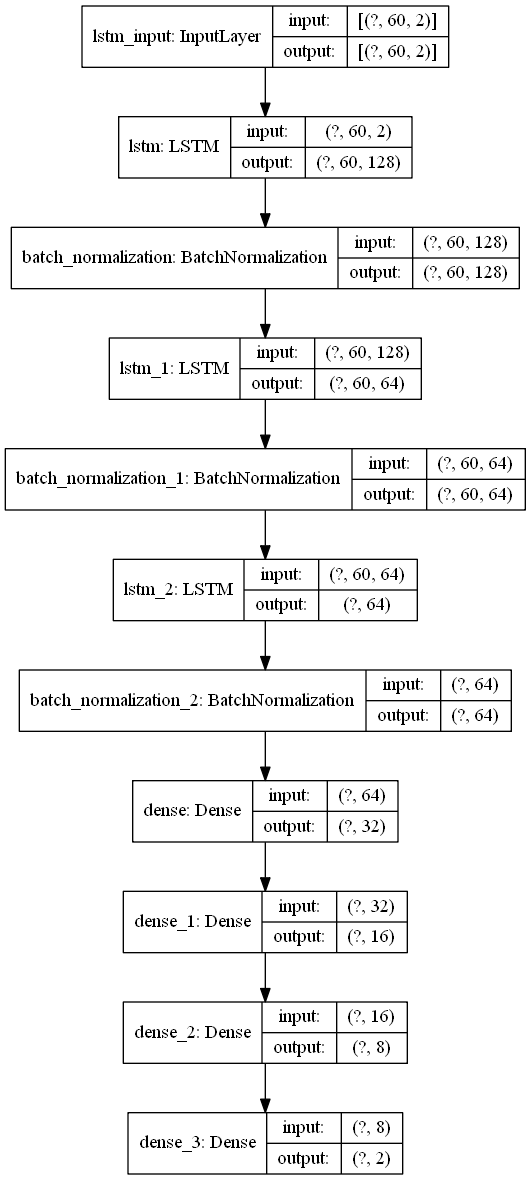

In [29]:
from tensorflow.keras.utils import plot_model
model.summary()
plot_model(model, 'model.png', show_shapes=True)